In [ ]:
!pip install tensorflow pandas matplotlib tensorflow-datasets ipywidgets

In [4]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
#Activating Gpus and limiting memory growth to prevent blowing out VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
#list out gpus
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
#download and import dataset using tensorflow dataset api
ds = tfds.load('fashion_mnist', split='train')

In [12]:
#Getting data out of pipeline
dataIterator = ds.as_numpy_iterator()

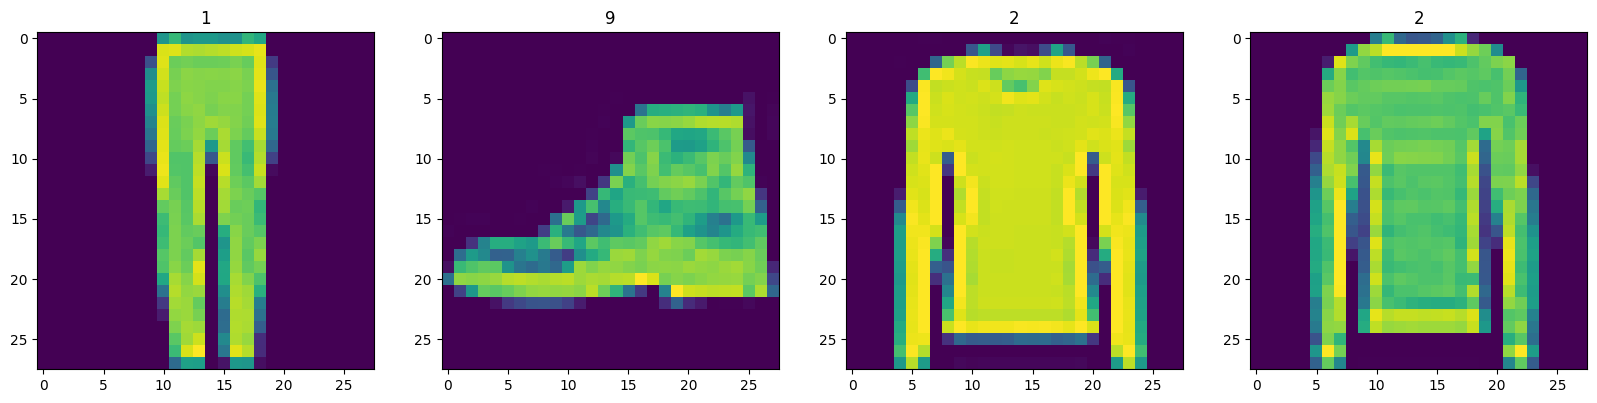

In [15]:
#making subplots to visualise
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  #grab an image
  sample = dataIterator.next()

  #plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [ ]:
#Scale and return images from the data dict because our
#dataset from tfds has images and labels
def scale_images(data):
  image = data['image']
  return image/255

In [ ]:
#reload the dataset
ds = tfds.load('fashion_mnist', split='train')

#Running images to scale each and every image
ds = ds.map(scale_images)

#cache data
ds = ds.cache()

ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [19]:
#Importing the sequential api for the generator and the discriminator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [28]:
def build_generator():
  model = Sequential()

  #BATCH 1

  #takes in random values and reshapes into 7x7x128
  model.add(Dense(7*7*128, input_dim=128))
  #to cater for non linearities
  model.add(LeakyReLU(0.2))
  #reshape into 7x7x128
  model.add(Reshape((7,7,128)))

  # UPSAMPLING BLOCK 1

  #doubles the space making it 14x14x128
  model.add(UpSampling2D())
  #passing thorugh a convolutional layer with kernel size 5
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  #UPSAMPLING BLOCK 2

  #current shape :- 28, 28
  #doubles the space making it 14x14x128
  model.add(UpSampling2D())
  #passing thorugh a convolutional layer with kernel size 5
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  #Convolutional BLOCK 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  #Convolutional BLOCK 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  #Final Conv layer to get one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

  return model

**Upsampling - early solution**:-

We can actually use the same upsampling block to get to the image shape and reconstruct the array to an image.

The upsampling block doubles the shape of the array.

But, its not enough convolutional layers for a realistic image. So we can't directly upsample.

In [30]:
# defining generator
generator = build_generator()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_7 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 18ms/step


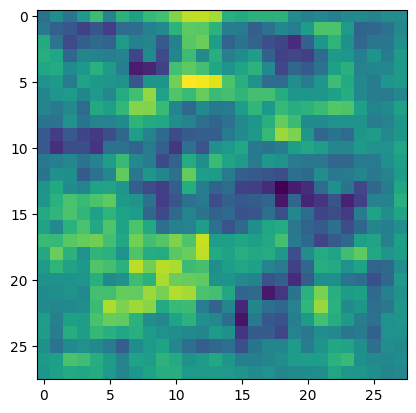

In [35]:
img = generator.predict(np.random.randn(1,128,1))
plt.imshow(np.squeeze(img))

In [40]:
#building a discriminator
def build_discriminator():
  model = Sequential()

  #First convolutional layer block expecting a 28x28 image of grayscale having 32 filters with 5x5 shape

  #here we aren't speciying padding=same, So its going to condense the information.
  model.add(Conv2D(32, 5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second convolutional layer block which doesn't take input shape parameter because its not the first one.
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Third convolutional layer block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Fourth convolutional layer block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to Dense model
  model.add(Flatten())
  model.add(Dropout(0.4))
  #we are defining that 1 here represents a false image and 0 is a real image
  model.add(Dense(1, activation='sigmoid'))

  return model

In [41]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)      

In [42]:
discriminator.predict(img)

1/1 [==============================] - 0s 364ms/step


array([[0.50162464]], dtype=float32)

**Constructing a Training loop**

This part is crucial and relatively harder because we need to take into consideration the rate at which the generator is training and the rate of learning of discriminator. We need to find a balance this.

One way to do it is to inject random noise, almost like trick the discriminator and slow it down.

In [47]:
#Constructing a training loop

#Adam and BCE are going to be optimizer and losss respectively for both
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

#making sure that the discriminator is learning slower than the generator
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [44]:
#importing base model class to the subclass
from keras.models import Model

In [76]:
class FashGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    #pass args and kwargs to base class
    super().__init__(*args, **kwargs)

    #create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator
    pass

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    pass

  #our batch consists of 128 images of dimensions 28x28
  def train_step(self, batch):

    real_images = batch
    # Ensure that the shape argument is passed as a tuple to tf.random.normal
    fake_images = self.generator(tf.random.normal((128,128,1)), training = False)

    #train the discriminator
    with tf.GradientTape() as d_tape:
      #passing the real and fake images for disc model
      yhat_real = self.discriminator(tf.expand_dims(real_images, axis=0), training=True) #when we are passing with training=True it means the dropout layers are going to activate otherwise the dropout layers wont activate
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)



      #create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      #add noise to outputs
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      #calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    #apply backpropagation - Neural Network Learning
    d_gradient = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

    #train the generator
    with tf.GradientTape() as g_tape:

      #generate new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

      predicted_labels = self.discriminator(gen_images, training=False)

      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}
    pass

  def test_step(self):
    pass

In [77]:
#create an instance of the class and compile
fashgan = FashGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [78]:
#Build callback
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [79]:
class ModelMonitor(Callback):

    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
#Training
hist = fashgan.fit(ds.map(lambda x: x['image']), epochs=20, callbacks=[ModelMonitor()]) # Select the 'image' key from the dataset